This notebook is running on Amazon Sagemaker. 

In [2]:
import os
import random
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, auc, classification_report, 
                             confusion_matrix, f1_score, make_scorer, 
                             precision_score, precision_recall_fscore_support, 
                             recall_score, roc_auc_score, roc_curve)
from sklearn.impute import SimpleImputer

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import (Concatenate, Dense, Dropout, 
                                     Flatten, GlobalAveragePooling2D, 
                                     GlobalMaxPooling2D, Input)
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2


pd.set_option('display.max_rows', 500)
pd.set_option("display.max_columns", 500)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# Set environment variables for reproducibility
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = '0'

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


2024-08-12 19:28:43.574869: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 19:28:43.708930: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-08-12 19:28:43.709058: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2024-08-12 19:28:43.709256: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-1

In [3]:
!nvidia-smi


Mon Aug 12 19:28:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:1E.0 Off |                    0 |
| N/A   38C    P0              29W /  70W |      2MiB / 15360MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Data Ingest

In [4]:
import pickle
dataset_train = pickle.loads(open('full_dataset_train.json', 'rb').read())
dataset_test = pickle.loads(open('full_dataset_test.json', 'rb').read())

2024-08-12 19:29:04.340178: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-12 19:29:04.349278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-12 19:29:04.351026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-12 19:29:04.353224: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebu

In [5]:
print(dataset_train.keys())
print(dataset_test.keys())

dict_keys(['train_frame_features', 'train_tag_features', 'train_audio_features', 'train_labels', 'train_creative_code', 'tag_feature_name'])
dict_keys(['test_frame_features', 'test_tag_features', 'test_audio_features', 'test_labels', 'test_creative_code'])


In [6]:
train_frame_features = dataset_train['train_frame_features']
train_tag_features = dataset_train['train_tag_features']
train_audio_features = dataset_train['train_audio_features']
train_labels = dataset_train['train_labels']
train_creative_code = dataset_train['train_creative_code']
tag_column_name = dataset_train['tag_feature_name']

test_frame_features = dataset_test['test_frame_features']
test_tag_features = dataset_test['test_tag_features']
test_audio_features = dataset_test['test_audio_features']
test_labels = dataset_test['test_labels']
test_creative_code = dataset_test['test_creative_code']

print("Shapes:")
print("train_frame_features:", train_frame_features.shape)
print("train_tag_features:", train_tag_features.shape)
print("train_audio_features:", train_audio_features.shape)
print("train_labels:", train_labels.shape)


Shapes:
train_frame_features: (980, 6, 224, 224, 3)
train_tag_features: (980, 219)
train_audio_features: (980, 1024)
train_labels: (980, 1)


In [7]:
TAG_N = train_tag_features.shape[1]

In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [9]:
baseline_features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']

indices = [tag_column_name.index(feature) for feature in baseline_features]

print(indices)

train_tag_base_features = tf.gather(train_tag_features, indices, axis=1)  
test_tag_base_features = tf.gather(test_tag_features, indices, axis=1)  


[147, 179, 116, 118]


In [11]:
nan_mask = tf.math.is_nan(train_tag_base_features)
nan_exists = tf.reduce_any(nan_mask)
print("\nDo any NaN values exist in the selected columns?")
print(nan_exists.numpy())

nan_mask = tf.math.is_nan(test_tag_base_features)
nan_exists = tf.reduce_any(nan_mask)
print("\nDo any NaN values exist in the selected columns?")
print(nan_exists.numpy())


Do any NaN values exist in the selected columns?
False

Do any NaN values exist in the selected columns?
False


## Define Functions

In [12]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K


class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.numpy().reshape(-1)), y=train_labels.numpy().reshape(-1))
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

def evaluate_default(predictions, test_labels=test_labels, threshold=0.5):
    predictions_binary = (predictions > threshold).astype(int)

    accuracy = accuracy_score(test_labels, predictions_binary)
    precision = precision_score(test_labels, predictions_binary)
    recall = recall_score(test_labels, predictions_binary)
    f1 = f1_score(test_labels, predictions_binary)
    auc = roc_auc_score(test_labels, predictions)

    print(f"AUC: {auc}")
    
     # Print classification report
    print("\n"+"*"*30+"Classification Report (Threshold = {threshold}):".format(threshold=threshold))
    print(classification_report(test_labels, predictions_binary))
    print(confusion_matrix(test_labels, predictions_binary.reshape(-1)))

def plot_metrics_vs_threshold(y_test, predictions):
    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    
    plot_ths = []
    recall_at_thresholds = []
    precision_at_thresholds = []
    f1_at_thresholds = []
    marco_recall_thresholds = []
    best_marco_recall = -10e100
    best_marco_recall_threshold = 0
    # Calculate recall, precision, and F1 score at each threshold
    for threshold in thresholds:
        if threshold > 1: continue 
        y_pred_threshold = (predictions > threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_threshold, average=None)
        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred_threshold, average='macro')
        recall_at_thresholds.append(recall[1])
        precision_at_thresholds.append(precision[1])
        f1_at_thresholds.append(f1[1])
        marco_recall_thresholds.append(recall_macro)
        plot_ths.append(threshold)
        # print(round(threshold,2), recall_macro)
        if (recall_macro > best_marco_recall) and (recall[0] > 0.7) and (recall[1] > 0.3):
            best_marco_recall = recall_macro
            best_marco_recall_threshold = threshold
    
    print("\n"+"*"*30+"Evaluate metrics vs. Threshold for true class + Marco Recall")
        
    # Plot the metrics
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharex=True)

    # Plot recall vs. threshold
    axs[0].plot(plot_ths, recall_at_thresholds, label='Recall', color='blue')
    axs[0].set_xlabel('Threshold')
    axs[0].set_xlim([0,1])
    axs[0].set_ylabel('Recall')
    axs[0].set_title('Recall vs. Threshold')
    axs[0].legend()
    axs[0].grid(True)

    # Plot precision vs. threshold
    axs[1].plot(plot_ths, precision_at_thresholds, label='Precision', color='green')
    axs[1].set_xlabel('Threshold')
    axs[0].set_xlim([0,1])
    axs[1].set_ylabel('Precision')
    axs[1].set_title('Precision vs. Threshold')
    axs[1].legend()
    axs[1].grid(True)

    # Plot F1 score vs. threshold
    axs[2].plot(plot_ths, f1_at_thresholds, label='F1 Score', color='red')
    axs[2].set_xlabel('Threshold')
    axs[0].set_xlim([0,1])
    axs[2].set_ylabel('F1 Score')
    axs[2].set_title('F1 Score vs. Threshold')
    axs[2].legend()
    axs[2].grid(True)

    # Plot F1 score vs. threshold
    axs[3].plot(plot_ths, marco_recall_thresholds, label='Marco Recall', color='black')
    axs[3].set_xlabel('Threshold')
    axs[0].set_xlim([0,1])
    axs[3].set_ylabel('Marco Recall')
    axs[3].set_title('Marco Recall vs. Threshold')
    axs[3].legend()
    axs[3].grid(True)

    # Show the plots
    plt.tight_layout()
    plt.show()

    print()
    
    print('best recall_macro', best_marco_recall)
    print('best_marco_recall_threshold', best_marco_recall_threshold)
    if best_marco_recall_threshold > 0:
        evaluate_default(predictions, y_test, best_marco_recall_threshold)
    else: 
        print('Cannot Beat Baseline.')

def evaluate_classification(y_true, y_pred_proba):
    y_pred = (np.array(y_pred_proba) > 0.5).astype(int)
    auc = roc_auc_score(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred)

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    
    return {
        'AUC': auc,
        'Accuracy': accuracy,
        '0-Precision': precision[0],
        '0-Recall': recall[0],
        '0-F1-Score': f1[0],
        '1-Precision': precision[1],
        '1-Recall': recall[1],
        '1-F1-Score': f1[1],
        'Macro-Precision': precision_macro,
        'Macro-Recall': recall_macro,
        'Macro-F1-Score': f1_macro,
        'Weighted-Precision': precision_weighted,
        'Weighted-Recall': recall_weighted,
        'Weighted-F1-Score': f1_weighted
    }


In [13]:

def focal_loss_with_class_weights(gamma=2., alpha=0.25, class_weight=None):
    ## Not used in current models - did nt perform well 
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_loss = -alpha_t * K.pow(1 - p_t, gamma) * K.log(p_t)
        
        if class_weight is not None:
            weights = tf.reduce_sum(class_weight * y_true, axis=-1)
            focal_loss *= weights
        
        return K.mean(focal_loss)
    return focal_loss_fixed

def train_model(model11, model_name, trainset, trainlabels, valset, vallabels, 
                epochs, batch_size,
                if_callback, class_weights_setup):
    checkpoint_filepath = 'model_checkpoints/{model_name}/best_model-{datetime}.h5'.format(model_name=model_name, datetime=datetime.today().strftime('%Y-%m-%d_%H:%M:%S'))
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_loss',  
        mode='min',  
        save_best_only=True
    ) 
    
    if if_callback:
        callbacks_setup = [model_checkpoint_callback]
    else: 
        callbacks_setup = None

    history = model11.fit(trainset, 
                          trainlabels, 
                          epochs=epochs, 
                          batch_size=batch_size,
                          class_weight=class_weights_setup,
                          callbacks=callbacks_setup,
                          validation_data=(valset, vallabels))

    # Plot the training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()
    
    plt.plot(history.history['auc'], label='Training AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.title('Training and Validation AUC')
    plt.show()
 
    return model11

## MODEL 1 One image + output 

In [14]:

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet_base.layers:
    layer.trainable = False

input_image = Input(shape=(224, 224, 3))

base_model = resnet_base(input_image)
x = Flatten()(base_model)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model11 = Model(inputs=input_image, outputs=output)

model11.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[AUC(name='auc', curve='ROC')]
              )
model11.summary()

# Total params: 75,100,033
# Trainable params: 51,512,321
# Non-trainable params: 23,587,712

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 74,968,961
Trainable params: 51,381,249
Non-tra

Epoch 1/20


2024-08-12 19:29:25.807975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2024-08-12 19:29:28.413215: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x5654455c55f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-12 19:29:28.413256: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-08-12 19:29:28.418995: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-12 19:29:28.563529: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 [==============================] - 21s 478ms/step - loss: 99.1845 - auc: 0.4846 - val_loss: 1.9615 - val_auc: 0.6027
Epoch 2/20
31/31 [==============================] - 13s 418ms/step - loss: 2.0330 - auc: 0.6264 - val_loss: 1.2612 - val_auc: 0.5306
Epoch 3/20
31/31 [==============================] - 4s 144ms/step - loss: 1.6571 - auc: 0.6224 - val_loss: 1.3817 - val_auc: 0.5149
Epoch 4/20
31/31 [==============================] - 13s 416ms/step - loss: 1.8289 - auc: 0.6874 - val_loss: 1.1638 - val_auc: 0.5774
Epoch 5/20
31/31 [==============================] - 13s 417ms/step - loss: 1.1460 - auc: 0.6232 - val_loss: 0.9202 - val_auc: 0.6302
Epoch 6/20
31/31 [==============================] - 13s 414ms/step - loss: 0.9054 - auc: 0.6976 - val_loss: 0.6870 - val_auc: 0.6029
Epoch 7/20
31/31 [==============================] - 4s 144ms/step - loss: 0.8892 - auc: 0.6988 - val_loss: 0.6929 - val_auc: 0.5721
Epoch 8/20
31/31 [==============================] - 4s 144ms/step - loss: 1.2449 

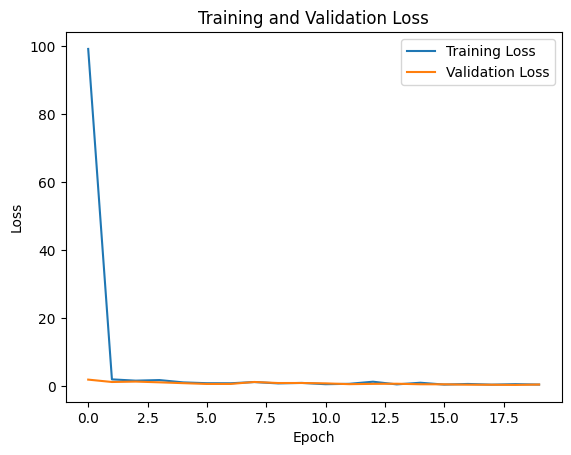

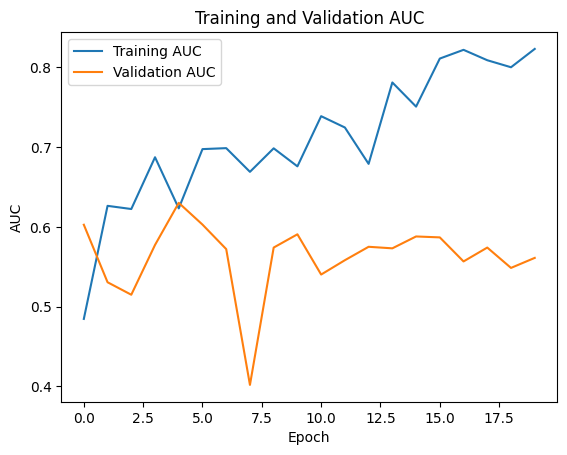

In [15]:
model_name = 'model11'
trainset = train_frame_one_image
trainlabels = train_labels
valset = test_frame_one_image 
vallabels = test_labels
class_weights_setup = class_weights_dict 
model11 = train_model(model11, model_name, trainset, trainlabels, valset, vallabels, 
                     epochs=20, batch_size=32,
                     if_callback=True, class_weights_setup=class_weights_dict)


8/8 [==============================] - 1s 106ms/step - loss: 0.5180 - auc: 0.5611
Test Loss: 0.5179897546768188, Test Accuracy: 0.5611218810081482
8/8 [==============================] - 2s 107ms/step
AUC: 0.5588007736943907

******************************Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

         0.0       0.96      0.75      0.84       235
         1.0       0.06      0.36      0.11        11

    accuracy                           0.74       246
   macro avg       0.51      0.56      0.48       246
weighted avg       0.92      0.74      0.81       246

[[177  58]
 [  7   4]]

******************************Evaluate metrics vs. Threshold for true class + Marco Recall


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


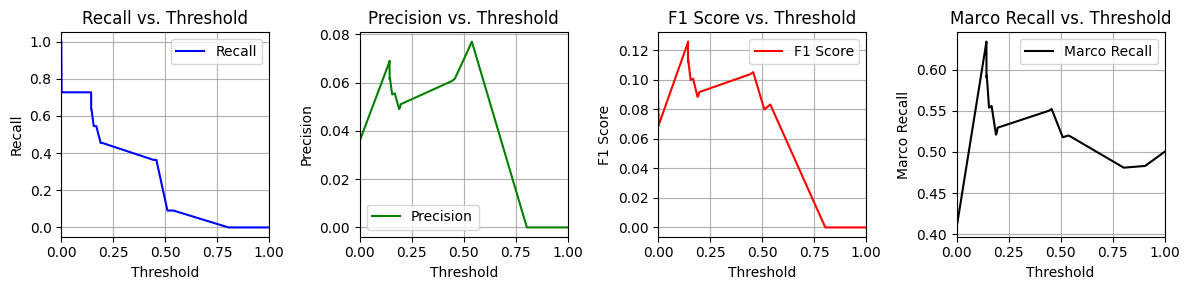


best recall_macro 0.5520309477756287
best_marco_recall_threshold 0.4570379
AUC: 0.5588007736943907

******************************Classification Report (Threshold = 0.45703789591789246):
              precision    recall  f1-score   support

         0.0       0.96      0.74      0.84       235
         1.0       0.06      0.36      0.11        11

    accuracy                           0.72       246
   macro avg       0.51      0.55      0.47       246
weighted avg       0.92      0.72      0.80       246

[[174  61]
 [  7   4]]


In [16]:
evaluation = model11.evaluate(valset, vallabels)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

model11_predictions = model11.predict(valset)

evaluate_default(model11_predictions)

plot_metrics_vs_threshold(vallabels, model11_predictions)


In [17]:
clear_session()


## MODEL 2: Pooling Way (Inspired by MVCNN)

### MODEL 2.1 total 6 images  

In [18]:
l2_reg = keras.regularizers.l2(0.004)

pre_trained_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in pre_trained_base.layers:
    layer.trainable = False

input_frames = Input(shape=(6, 224, 224, 3))
input_images = tf.unstack(input_frames, axis=1)

view_features = [pre_trained_base(input_image) for input_image in input_images]
view_pool = tf.reduce_max(tf.stack(view_features, axis=1), axis=1)

flatten_view = Flatten()(view_pool)

# # Fully connected layer (1)
# fc6 = Dense(4096, activation='relu', kernel_regularizer=l2_reg, name='fc6')(flatten_view)
# dropout6 = Dropout(0.6, name='dropout6')(fc6)

# fc7 = Dense(4096, activation='relu', kernel_regularizer=l2_reg, name='fc7')(dropout6)
# dropout7 = Dropout(0.6, name='dropout7')(fc7)

# Fully connected layer (2)
fc6 = Dense(512, activation='relu', kernel_regularizer=l2_reg, name='fc6')(flatten_view)
dropout6 = Dropout(0.6, name='dropout6')(fc6)

fc7 = Dense(256, activation='relu', kernel_regularizer=l2_reg, name='fc7')(dropout6)
dropout7 = Dropout(0.6, name='dropout7')(fc7)

fc8 = Dense(1, activation='sigmoid', kernel_regularizer=l2_reg, name='fc8')(dropout7)

model21 = Model(inputs=input_frames, outputs=fc8)

model21.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[AUC(name='auc', curve='ROC')])

model21.summary()

# resnet50 - original 4096 unit for fc6 fc7
# Total params: 451,419,009
# Trainable params: 427,831,297
# Non-trainable params: 23,587,712

# resnet50 - 512 + 256 - simpler network 
# Total params: 75,100,033
# Trainable params: 51,512,321
# Non-trainable params: 23,587,712


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 224, 224  0           []                               
                                , 3)]                                                             
                                                                                                  
 tf.unstack (TFOpLambda)        [(None, 224, 224, 3  0           ['input_2[0][0]']                
                                ),                                                                
                                 (None, 224, 224, 3                                               
                                ),                                                                
                                 (None, 224, 224, 3                                           

Epoch 1/20
31/31 [==============================] - 55s 1s/step - loss: 354.5728 - auc: 0.4957 - val_loss: 545.9612 - val_auc: 0.5000
Epoch 2/20
31/31 [==============================] - 33s 1s/step - loss: 302.5008 - auc: 0.5694 - val_loss: 183.2564 - val_auc: 0.6170
Epoch 3/20
31/31 [==============================] - 34s 1s/step - loss: 238.3304 - auc: 0.6071 - val_loss: 35.5227 - val_auc: 0.4574
Epoch 4/20
31/31 [==============================] - 25s 825ms/step - loss: 175.4072 - auc: 0.6103 - val_loss: 86.3112 - val_auc: 0.5555
Epoch 5/20
31/31 [==============================] - 34s 1s/step - loss: 96.6142 - auc: 0.6709 - val_loss: 26.8179 - val_auc: 0.4851
Epoch 6/20
31/31 [==============================] - 33s 1s/step - loss: 72.7176 - auc: 0.7143 - val_loss: 25.6738 - val_auc: 0.5170
Epoch 7/20
31/31 [==============================] - 34s 1s/step - loss: 57.4370 - auc: 0.7316 - val_loss: 19.8601 - val_auc: 0.4574
Epoch 8/20
31/31 [==============================] - 25s 823ms/step 

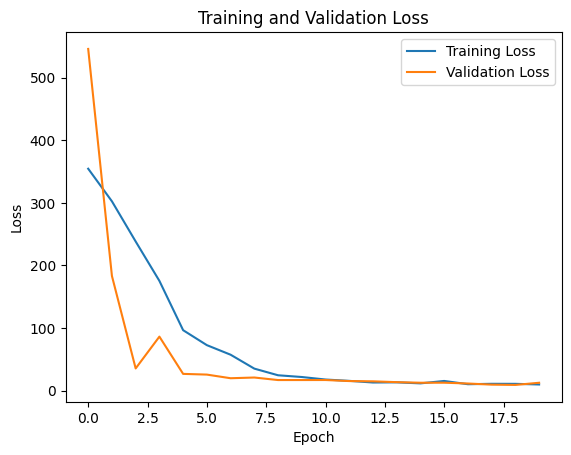

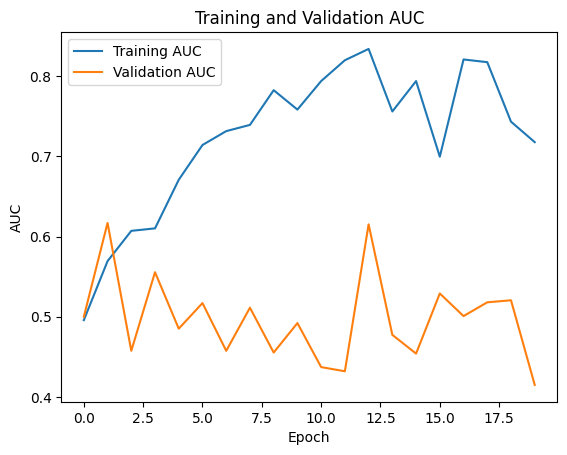

In [19]:
# ml.g4dn.4xlarge --> works for VGG16(7,7,512) with batch_size=32 but not Resnet50(7,7,2048) with batch_size even 4
trainset = train_frame_features
trainlabels = train_labels
valset = test_frame_features 
vallabels = test_labels
class_weights_setup = class_weights_dict 
model21 = train_model(model21, 'model21', trainset, trainlabels, valset, vallabels, 
                     epochs=20, batch_size=32,
                     if_callback=True, class_weights_setup=class_weights_dict)


8/8 [==============================] - 5s 625ms/step - loss: 12.6152 - auc: 0.4149
Test Loss: 12.615193367004395, Test Accuracy: 0.41489365696907043
8/8 [==============================] - 10s 640ms/step
AUC: 0.4239845261121857

******************************Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

         0.0       0.94      0.60      0.74       235
         1.0       0.02      0.18      0.04        11

    accuracy                           0.59       246
   macro avg       0.48      0.39      0.39       246
weighted avg       0.90      0.59      0.70       246

[[142  93]
 [  9   2]]

******************************Evaluate metrics vs. Threshold for true class + Marco Recall


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


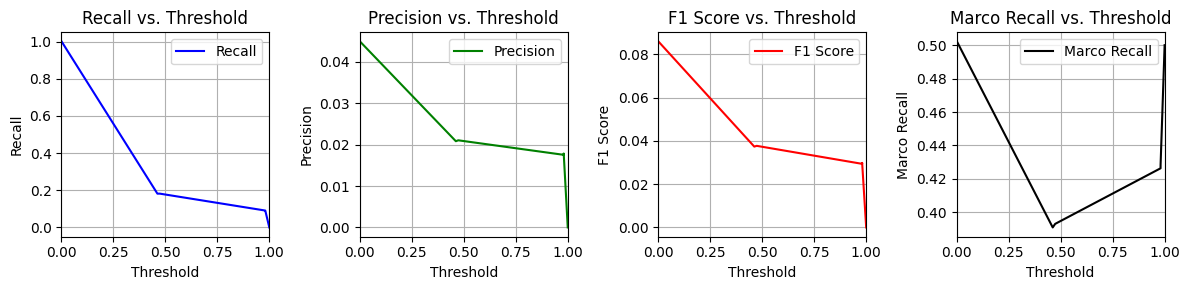


best recall_macro -1e+101
best_marco_recall_threshold 0
Cannot Beat Baseline.


In [20]:
evaluation = model21.evaluate(valset, vallabels)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")
model21_predictions = model21.predict(valset)
evaluate_default(model21_predictions)
plot_metrics_vs_threshold(vallabels, model21_predictions)


### MODEL 2.2 total 6 images + audio 

In [21]:
l2_reg = keras.regularizers.l2(0.004)

pre_trained_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in pre_trained_base.layers:
    layer.trainable = False

input_frames = Input(shape=(6, 224, 224, 3))
input_images = tf.unstack(input_frames, axis=1)

input_audio = Input(shape=(1024,), name='audio_input')  # Assuming YAMNet outputs 1024-dimensional embeddings

view_features = [pre_trained_base(input_image) for input_image in input_images]
view_pool = tf.reduce_max(tf.stack(view_features, axis=1), axis=1)

flatten_view = Flatten()(view_pool)

combined_features = Concatenate()([flatten_view, input_audio])

fc6 = Dense(512, activation='relu', kernel_regularizer=l2_reg, name='fc6')(combined_features)
dropout6 = Dropout(0.6, name='dropout6')(fc6)

fc7 = Dense(256, activation='relu', kernel_regularizer=l2_reg, name='fc7')(dropout6)
dropout7 = Dropout(0.6, name='dropout7')(fc7)

fc8 = Dense(1, activation='sigmoid', kernel_regularizer=l2_reg, name='fc8')(dropout7)

model22 = Model(inputs=[input_frames, input_audio], outputs=fc8)

model22.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[AUC(name='auc', curve='ROC')])

model22.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 6, 224, 224  0           []                               
                                , 3)]                                                             
                                                                                                  
 tf.unstack_1 (TFOpLambda)      [(None, 224, 224, 3  0           ['input_4[0][0]']                
                                ),                                                                
                                 (None, 224, 224, 3                                               
                                ),                                                                
                                 (None, 224, 224, 3                                         

Epoch 1/20
31/31 [==============================] - 55s 1s/step - loss: 351.8368 - auc: 0.4861 - val_loss: 331.3555 - val_auc: 0.5000
Epoch 2/20
31/31 [==============================] - 34s 1s/step - loss: 293.3217 - auc: 0.5358 - val_loss: 22.0364 - val_auc: 0.4979
Epoch 3/20
31/31 [==============================] - 25s 824ms/step - loss: 242.6154 - auc: 0.5524 - val_loss: 23.0341 - val_auc: 0.4830
Epoch 4/20
31/31 [==============================] - 25s 826ms/step - loss: 188.6315 - auc: 0.6403 - val_loss: 66.5764 - val_auc: 0.6621
Epoch 5/20
31/31 [==============================] - 25s 827ms/step - loss: 150.8658 - auc: 0.6063 - val_loss: 27.7071 - val_auc: 0.5288
Epoch 6/20
31/31 [==============================] - 25s 827ms/step - loss: 75.9418 - auc: 0.6561 - val_loss: 81.3682 - val_auc: 0.6213
Epoch 7/20
31/31 [==============================] - 25s 828ms/step - loss: 52.3584 - auc: 0.6822 - val_loss: 25.7199 - val_auc: 0.5406
Epoch 8/20
31/31 [==============================] - 25s

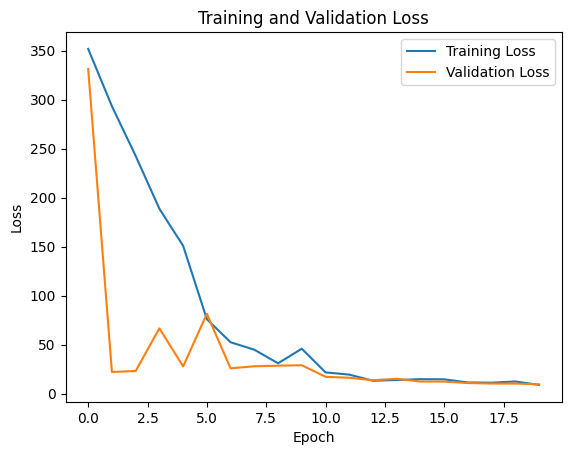

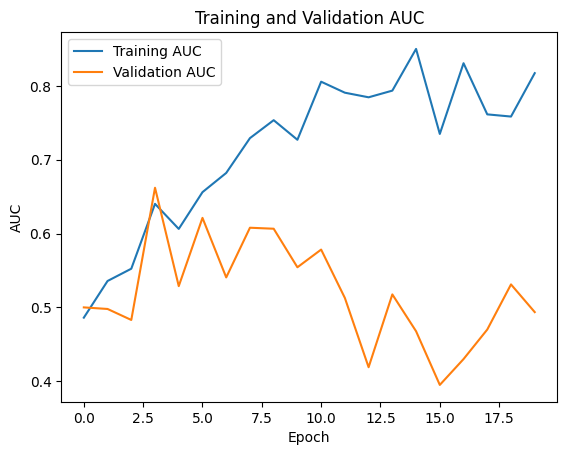

In [22]:

trainset = [train_frame_features, train_audio_features]
trainlabels = train_labels
valset = [test_frame_features, test_audio_features] 
vallabels = test_labels
class_weights_setup = class_weights_dict 
model22 = train_model(model22, 'model22', trainset, trainlabels, valset, vallabels, 
                     epochs=20, batch_size=32,
                     if_callback=True, 
                      class_weights_setup=class_weights_dict)



8/8 [==============================] - 5s 622ms/step - loss: 9.4071 - auc: 0.4936
Test Loss: 9.407052040100098, Test Accuracy: 0.4936169981956482
8/8 [==============================] - 10s 639ms/step
AUC: 0.49361702127659574

******************************Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93       235
         1.0       0.00      0.00      0.00        11

    accuracy                           0.87       246
   macro avg       0.48      0.46      0.47       246
weighted avg       0.91      0.87      0.89       246

[[215  20]
 [ 11   0]]

******************************Evaluate metrics vs. Threshold for true class + Marco Recall


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


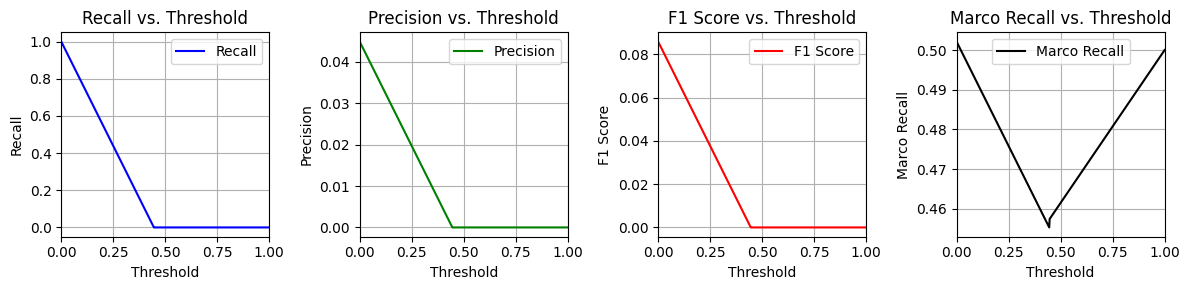


best recall_macro -1e+101
best_marco_recall_threshold 0
Cannot Beat Baseline.


In [23]:

evaluation = model22.evaluate(valset, vallabels)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

model22_predictions = model22.predict(valset)

evaluate_default(model22_predictions)

plot_metrics_vs_threshold(vallabels, model22_predictions)


### MODEL 2.3 total 6 images + audio + TAG

In [24]:

l2_reg = keras.regularizers.l2(0.004)

pre_trained_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in pre_trained_base.layers:
    layer.trainable = False

input_frames = Input(shape=(6, 224, 224, 3))
input_images = tf.unstack(input_frames, axis=1)

input_audio = Input(shape=(1024,), name='audio_input')  # Assuming YAMNet outputs 1024-dimensional embeddings
input_tag = Input(shape=(TAG_N,), name='tag_input')  

view_features = [pre_trained_base(input_image) for input_image in input_images]

view_pool = tf.reduce_max(tf.stack(view_features, axis=1), axis=1)

flatten_view = Flatten()(view_pool)


combined_features = Concatenate()([flatten_view, input_audio, input_tag])

# Fully connected layer (2)
fc6 = Dense(512, activation='relu', kernel_regularizer=l2_reg, name='fc6')(combined_features)
dropout6 = Dropout(0.6, name='dropout6')(fc6)

fc7 = Dense(256, activation='relu', kernel_regularizer=l2_reg, name='fc7')(dropout6)
dropout7 = Dropout(0.6, name='dropout7')(fc7)

fc8 = Dense(1, activation='sigmoid', kernel_regularizer=l2_reg, name='fc8')(dropout7)

model23 = Model(inputs=[input_frames, input_audio, input_tag], outputs=fc8)


model23.compile(optimizer='adam', 
                loss='binary_crossentropy', 
              metrics=[AUC(name='auc', curve='ROC')])

model23.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 6, 224, 224  0           []                               
                                , 3)]                                                             
                                                                                                  
 tf.unstack_2 (TFOpLambda)      [(None, 224, 224, 3  0           ['input_6[0][0]']                
                                ),                                                                
                                 (None, 224, 224, 3                                               
                                ),                                                                
                                 (None, 224, 224, 3                                         

Epoch 1/20
31/31 [==============================] - 54s 1s/step - loss: 358.0481 - auc: 0.5185 - val_loss: 198.4808 - val_auc: 0.5319
Epoch 2/20
31/31 [==============================] - 34s 1s/step - loss: 320.7826 - auc: 0.5835 - val_loss: 26.9143 - val_auc: 0.5099
Epoch 3/20
31/31 [==============================] - 26s 826ms/step - loss: 264.2471 - auc: 0.4899 - val_loss: 38.1251 - val_auc: 0.6886
Epoch 4/20
31/31 [==============================] - 25s 827ms/step - loss: 150.5874 - auc: 0.6038 - val_loss: 133.7576 - val_auc: 0.5230
Epoch 5/20
31/31 [==============================] - 26s 829ms/step - loss: 82.2355 - auc: 0.5864 - val_loss: 30.3395 - val_auc: 0.5528
Epoch 6/20
31/31 [==============================] - 26s 828ms/step - loss: 51.4374 - auc: 0.6980 - val_loss: 46.5416 - val_auc: 0.6081
Epoch 7/20
31/31 [==============================] - 34s 1s/step - loss: 46.7422 - auc: 0.6806 - val_loss: 16.4927 - val_auc: 0.4489
Epoch 8/20
31/31 [==============================] - 26s 82

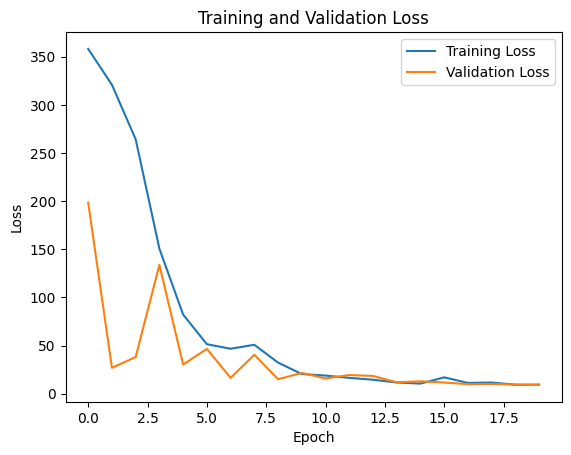

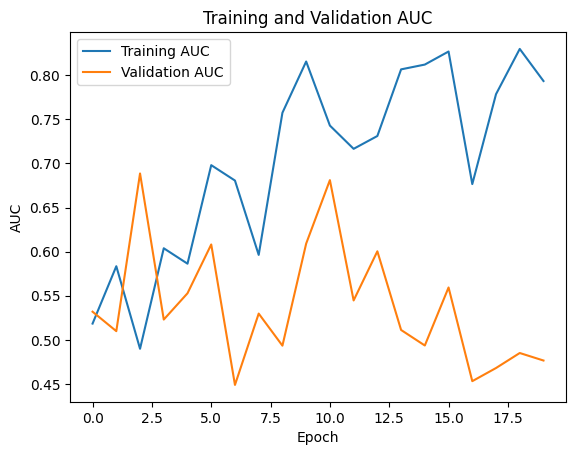

In [26]:
imputer = SimpleImputer(strategy='median')
train_tag_features_imputed = imputer.fit_transform(train_tag_features)
test_tag_features_imputed = imputer.transform(test_tag_features)


trainset = [train_frame_features, train_audio_features, train_tag_features_imputed]
trainlabels = train_labels
valset = [test_frame_features, test_audio_features, test_tag_features_imputed] 
vallabels = test_labels
class_weights_setup = class_weights_dict 
model23 = train_model(model23, 'model23', trainset, trainlabels, valset, vallabels, 
                     epochs=20, batch_size=32,
                     if_callback=True, class_weights_setup=class_weights_dict)



8/8 [==============================] - 5s 619ms/step - loss: 9.1603 - auc: 0.4766
Test Loss: 9.160261154174805, Test Accuracy: 0.47659575939178467
8/8 [==============================] - 10s 639ms/step
AUC: 0.4765957446808511

******************************Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       235
         1.0       0.00      0.00      0.00        11

    accuracy                           0.90       246
   macro avg       0.48      0.47      0.47       246
weighted avg       0.91      0.90      0.91       246

[[222  13]
 [ 11   0]]

******************************Evaluate metrics vs. Threshold for true class + Marco Recall


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


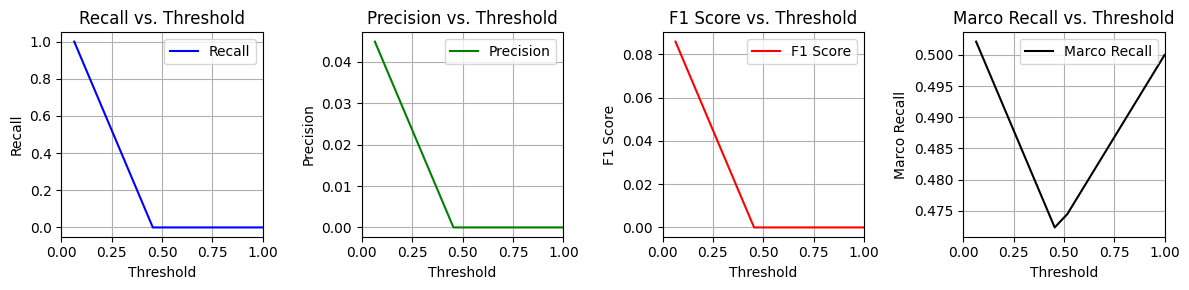


best recall_macro -1e+101
best_marco_recall_threshold 0
Cannot Beat Baseline.


In [27]:

evaluation = model23.evaluate(valset, vallabels)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

model23_predictions = model23.predict(valset)

evaluate_default(model23_predictions)

plot_metrics_vs_threshold(vallabels, model23_predictions)


### MODEL 2.4 6 images + audio + BASE TAG

In [28]:

l2_reg = keras.regularizers.l2(0.004)

pre_trained_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in pre_trained_base.layers:
    layer.trainable = False

input_frames = Input(shape=(6, 224, 224, 3))
input_images = tf.unstack(input_frames, axis=1)

input_audio = Input(shape=(1024,), name='audio_input')  # Assuming YAMNet outputs 1024-dimensional embeddings
input_tag = Input(shape=(4,), name='tag_input')  

view_features = [pre_trained_base(input_image) for input_image in input_images]
# Perform element-wise maximum to combine the view features
view_pool = tf.reduce_max(tf.stack(view_features, axis=1), axis=1)

flatten_view = Flatten()(view_pool)

combined_features = Concatenate()([flatten_view, input_audio, input_tag])

# Fully connected layer (2)
fc6 = Dense(512, activation='relu', kernel_regularizer=l2_reg, name='fc6')(combined_features)
dropout6 = Dropout(0.6, name='dropout6')(fc6)

fc7 = Dense(256, activation='relu', kernel_regularizer=l2_reg, name='fc7')(dropout6)
dropout7 = Dropout(0.6, name='dropout7')(fc7)

fc8 = Dense(1, activation='sigmoid', kernel_regularizer=l2_reg, name='fc8')(dropout7)

model232 = Model(inputs=[input_frames, input_audio, input_tag], outputs=fc8)

model232.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[AUC(name='auc', curve='ROC')])

model232.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 6, 224, 224  0           []                               
                                , 3)]                                                             
                                                                                                  
 tf.unstack_3 (TFOpLambda)      [(None, 224, 224, 3  0           ['input_8[0][0]']                
                                ),                                                                
                                 (None, 224, 224, 3                                               
                                ),                                                                
                                 (None, 224, 224, 3                                         

Epoch 1/20
31/31 [==============================] - 54s 1s/step - loss: 321.3257 - auc: 0.4936 - val_loss: 73.3146 - val_auc: 0.5596
Epoch 2/20
31/31 [==============================] - 34s 1s/step - loss: 279.1448 - auc: 0.5946 - val_loss: 32.3607 - val_auc: 0.5000
Epoch 3/20
31/31 [==============================] - 34s 1s/step - loss: 234.6096 - auc: 0.5528 - val_loss: 23.9975 - val_auc: 0.4936
Epoch 4/20
31/31 [==============================] - 25s 824ms/step - loss: 119.9607 - auc: 0.6361 - val_loss: 46.8958 - val_auc: 0.5905
Epoch 5/20
31/31 [==============================] - 34s 1s/step - loss: 154.5090 - auc: 0.6245 - val_loss: 22.4277 - val_auc: 0.4532
Epoch 6/20
31/31 [==============================] - 25s 823ms/step - loss: 71.3326 - auc: 0.5951 - val_loss: 29.3601 - val_auc: 0.5689
Epoch 7/20
31/31 [==============================] - 34s 1s/step - loss: 36.9884 - auc: 0.7228 - val_loss: 17.9582 - val_auc: 0.4855
Epoch 8/20
31/31 [==============================] - 25s 823ms/ste

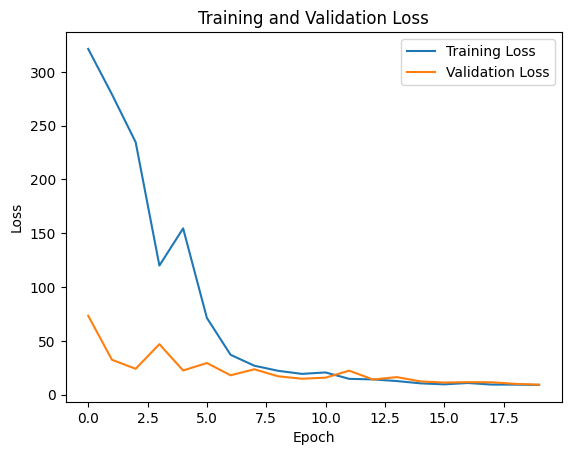

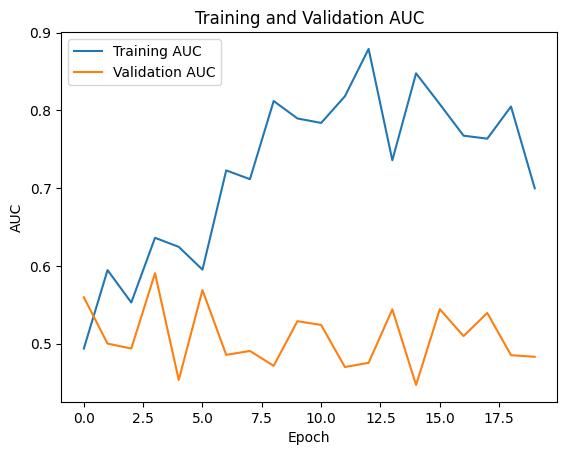

In [29]:

trainset = [train_frame_features, train_audio_features, train_tag_base_features]
trainlabels = train_labels
valset = [test_frame_features, test_audio_features, test_tag_base_features] 
vallabels = test_labels
class_weights_setup = class_weights_dict 
model232 = train_model(model232, 'model232', trainset, trainlabels, valset, vallabels, 
                     epochs=20, batch_size=32,
                     if_callback=True, 
                     class_weights_setup=class_weights_dict)

8/8 [==============================] - 5s 621ms/step - loss: 9.2384 - auc: 0.4830
Test Loss: 9.238409996032715, Test Accuracy: 0.4829787015914917
8/8 [==============================] - 11s 639ms/step
AUC: 0.48297872340425535

******************************Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94       235
         1.0       0.00      0.00      0.00        11

    accuracy                           0.89       246
   macro avg       0.48      0.47      0.47       246
weighted avg       0.91      0.89      0.90       246

[[220  15]
 [ 11   0]]

******************************Evaluate metrics vs. Threshold for true class + Marco Recall


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


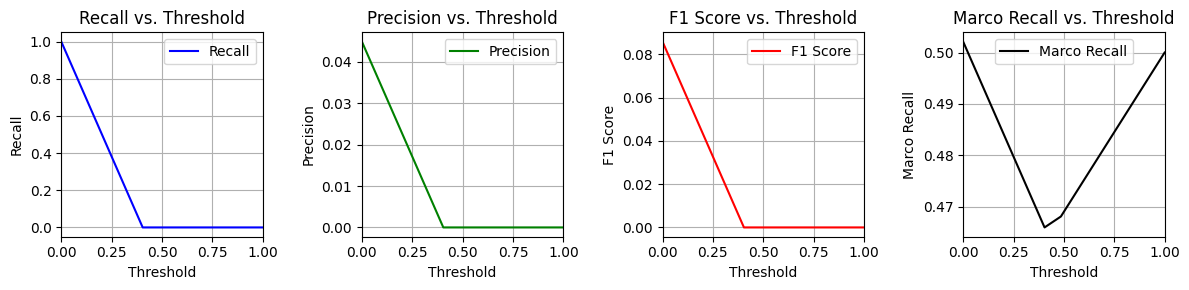


best recall_macro -1e+101
best_marco_recall_threshold 0
Cannot Beat Baseline.


In [30]:

evaluation = model232.evaluate(valset, vallabels)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

model232_predictions = model232.predict(valset)

evaluate_default(model232_predictions)

plot_metrics_vs_threshold(vallabels, model232_predictions)


## MODEL 3: Augment Way 



### Preprocess Data 

In [34]:
def predict_and_average(model, frame_features, audio_features, tag_features):
    predictions = []
    for i in range(frame_features.shape[1]):  # Iterate over the 6 images
        image = frame_features[:, i, :, :, :]
        audio = audio_features
        tags = tag_features
        pred = model.predict([image, audio, tags])
        predictions.append(pred)
    avg_predictions = np.mean(predictions, axis=0)
    return avg_predictions.reshape(-1)



In [35]:
train_creative_code_expanded = [item for item in train_creative_code for _ in range(6)]

train_frame_features_expanded = tf.reshape(train_frame_features, (-1, 224, 224, 3))

train_tag_features_expanded = tf.tile(train_tag_features[:, tf.newaxis, :], [1, 6, 1])
train_tag_features_expanded = tf.reshape(train_tag_features_expanded, (-1, 219))
train_tag_base_features_expanded = tf.tile(train_tag_base_features[:, tf.newaxis, :], [1, 6, 1])
train_tag_base_features_expanded = tf.reshape(train_tag_base_features_expanded, (-1, 4))

train_audio_features_expanded = tf.tile(train_audio_features[:, tf.newaxis, :], [1, 6, 1])
train_audio_features_expanded = tf.reshape(train_audio_features_expanded, (-1, 1024))

train_labels_expanded = tf.tile(train_labels[:, tf.newaxis, :], [1, 6, 1])
train_labels_expanded = tf.reshape(train_labels_expanded, (-1, 1))

# Check the shapes
print("Expanded train_frame_features shape:", train_frame_features_expanded.shape)
print("Expanded train_tag_features shape:", train_tag_features_expanded.shape)
print("Expanded train_tag_base_features shape:", train_tag_base_features_expanded.shape)
print("Expanded train_audio_features shape:", train_audio_features_expanded.shape)
print("Expanded train_labels shape:", train_labels_expanded.shape)
print("Expanded train_creative_code shape:", len(train_creative_code_expanded))



Expanded train_frame_features shape: (5880, 224, 224, 3)
Expanded train_tag_features shape: (5880, 219)
Expanded train_tag_base_features shape: (5880, 4)
Expanded train_audio_features shape: (5880, 1024)
Expanded train_labels shape: (5880, 1)
Expanded train_creative_code shape: 5880


In [36]:
test_frame_features_expanded = tf.reshape(test_frame_features, (-1, 224, 224, 3))

# Step 2: Duplicate the other features
test_tag_features_expanded = tf.tile(test_tag_features[:, tf.newaxis, :], [1, 6, 1])
test_tag_features_expanded = tf.reshape(test_tag_features_expanded, (-1, 219))

test_tag_base_features_expanded = tf.tile(test_tag_base_features[:, tf.newaxis, :], [1, 6, 1])
test_tag_base_features_expanded = tf.reshape(test_tag_base_features_expanded, (-1, 4))

test_audio_features_expanded = tf.tile(test_audio_features[:, tf.newaxis, :], [1, 6, 1])
test_audio_features_expanded = tf.reshape(test_audio_features_expanded, (-1, 1024))

test_labels_expanded = tf.tile(test_labels[:, tf.newaxis, :], [1, 6, 1])
test_labels_expanded = tf.reshape(test_labels_expanded, (-1, 1))

test_creative_code_expanded = [item for item in test_creative_code for _ in range(6)]

print("Expanded test_frame_features shape:", test_frame_features_expanded.shape)
print("Expanded test_tag_features shape:", test_tag_features_expanded.shape)
print("Expanded test_tag_base_features shape:", test_tag_base_features_expanded.shape)
print("Expanded test_audio_features shape:", test_audio_features_expanded.shape)
print("Expanded test_labels shape:", test_labels_expanded.shape)
print("Expanded test_creative_code shape:", len(test_creative_code_expanded))


Expanded test_frame_features shape: (1476, 224, 224, 3)
Expanded test_tag_features shape: (1476, 219)
Expanded test_tag_base_features shape: (1476, 4)
Expanded test_audio_features shape: (1476, 1024)
Expanded test_labels shape: (1476, 1)
Expanded test_creative_code shape: 1476


### MODEL 3.1 6 images 

In [37]:

l2_reg = l2(0.004)

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in resnet_base.layers:
    layer.trainable = False

input_image = Input(shape=(224, 224, 3), name='image_input')
image_features = resnet_base(input_image)
flatten_image = GlobalAveragePooling2D()(image_features)

fc1 = Dense(512, activation='relu', kernel_regularizer=l2_reg, name='fc1')(flatten_image)
dropout1 = Dropout(0.6, name='dropout1')(fc1)
fc2 = Dense(256, activation='relu', kernel_regularizer=l2_reg, name='fc2')(dropout1)
dropout2 = Dropout(0.6, name='dropout2')(fc2)
output = Dense(1, activation='sigmoid', kernel_regularizer=l2_reg, name='output')(dropout2)

# Define the model
model31 = Model(inputs=[input_image, input_audio, input_tag_base], outputs=output)
model31.compile(optimizer='adam', 
                loss='binary_crossentropy', 
                metrics=[tf.keras.metrics.AUC(name='auc', curve='ROC')])

model31.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['image_input[0][0]']            
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['resnet50[0][0]']               
 alAveragePooling2D)                                                                              
                                                                                            

Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 4.4455 - auc: 0.5269

2024-08-12 20:21:27.293838: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-12 20:21:27.293958: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-12 20:21:27.318749: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-12 20:21:27.318789: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

184/184 [==============================] - 33s 156ms/step - loss: 4.4455 - auc: 0.5269 - val_loss: 2.1666 - val_auc: 0.6396
Epoch 2/20
184/184 [==============================] - 26s 143ms/step - loss: 2.4675 - auc: 0.5859 - val_loss: 1.9875 - val_auc: 0.6195
Epoch 3/20
184/184 [==============================] - 26s 144ms/step - loss: 1.8802 - auc: 0.5774 - val_loss: 1.8347 - val_auc: 0.6920
Epoch 4/20
184/184 [==============================] - 27s 144ms/step - loss: 1.5778 - auc: 0.6111 - val_loss: 1.4399 - val_auc: 0.6757
Epoch 5/20
184/184 [==============================] - 26s 143ms/step - loss: 1.4266 - auc: 0.6168 - val_loss: 1.3848 - val_auc: 0.6978
Epoch 6/20
184/184 [==============================] - 26s 144ms/step - loss: 1.2388 - auc: 0.6158 - val_loss: 1.1669 - val_auc: 0.6666
Epoch 7/20
184/184 [==============================] - 26s 143ms/step - loss: 1.1179 - auc: 0.6325 - val_loss: 1.0954 - val_auc: 0.6821
Epoch 8/20
184/184 [==============================] - 26s 144ms/st

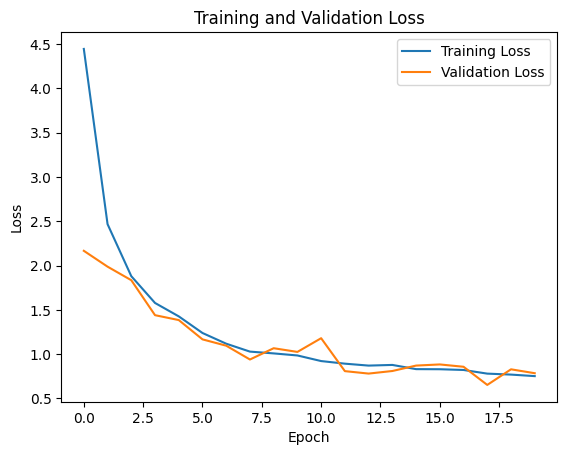

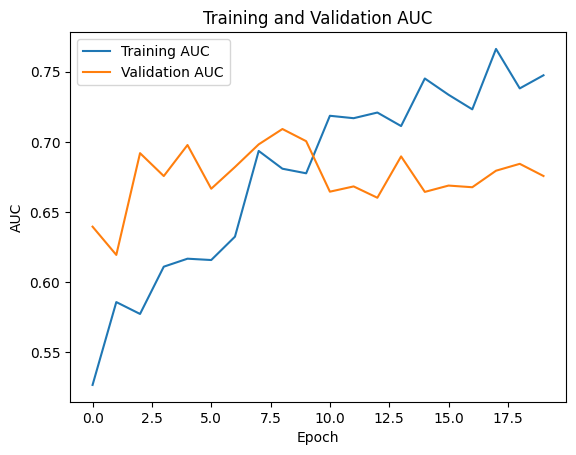

In [38]:

trainset = [train_frame_features_expanded, train_audio_features_expanded, train_tag_base_features_expanded]
trainlabels = train_labels_expanded
valset = [test_frame_features_expanded, test_audio_features_expanded, test_tag_base_features_expanded] 
vallabels = test_labels_expanded
class_weights_setup = class_weights_dict 
model31 = train_model(model31, 'model31', trainset, trainlabels, valset, vallabels, 
                     epochs=20, batch_size=32,
                     if_callback=True, class_weights_setup=class_weights_dict)


8/8 [==============================] - 1s 107ms/step
AUC: 0.7145067698259188

******************************Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

         0.0       0.98      0.70      0.82       235
         1.0       0.09      0.64      0.16        11

    accuracy                           0.70       246
   macro avg       0.53      0.67      0.49       246
weighted avg       0.94      0.70      0.79       246

[[165  70]
 [  4   7]]

******************************Evaluate metrics vs. Threshold for true class + Marco Recall


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


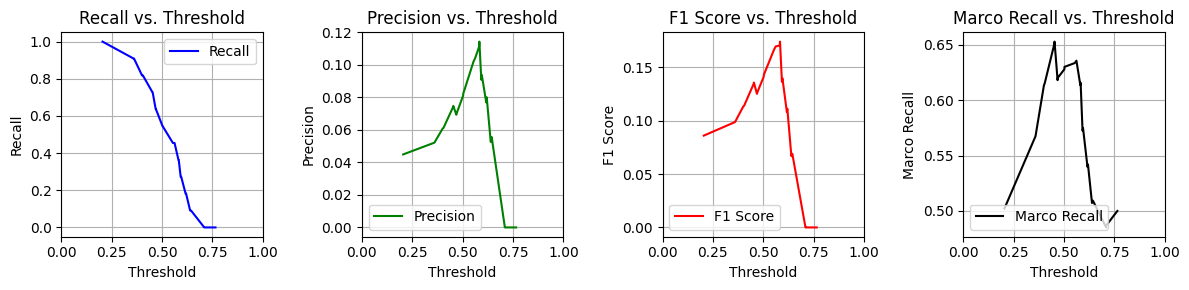


best recall_macro 0.6357833655705996
best_marco_recall_threshold 0.562237
AUC: 0.7145067698259188

******************************Classification Report (Threshold = 0.562237024307251):
              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89       235
         1.0       0.10      0.45      0.17        11

    accuracy                           0.80       246
   macro avg       0.54      0.64      0.53       246
weighted avg       0.93      0.80      0.85       246

[[192  43]
 [  6   5]]


In [39]:
model31_predictions = predict_and_average(model31, test_frame_features, test_audio_features, test_tag_base_features)

evaluate_default(model31_predictions)

plot_metrics_vs_threshold(test_labels, model31_predictions)



### MODEL 3.2 6 images + BASE TAG

In [40]:

l2_reg = l2(0.004)

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in resnet_base.layers:
    layer.trainable = False

input_tag_base = Input(shape=(4,), name='input_tag_base_input')  

input_image = Input(shape=(224, 224, 3), name='image_input')
image_features = resnet_base(input_image)
flatten_image = GlobalAveragePooling2D()(image_features)

combined_features = Concatenate()([flatten_image, input_tag_base])

fc1 = Dense(512, activation='relu', kernel_regularizer=l2_reg, name='fc1')(combined_features)
dropout1 = Dropout(0.6, name='dropout1')(fc1)
fc2 = Dense(256, activation='relu', kernel_regularizer=l2_reg, name='fc2')(dropout1)
dropout2 = Dropout(0.6, name='dropout2')(fc2)
output = Dense(1, activation='sigmoid', kernel_regularizer=l2_reg, name='output')(dropout2)

# Define the model
model32 = Model(inputs=[input_image, input_audio, input_tag_base], outputs=output)
model32.compile(optimizer='adam',  
                loss='binary_crossentropy', 
                metrics=[tf.keras.metrics.AUC(name='auc', curve='ROC')])

model32.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['image_input[0][0]']            
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 2048)        0           ['resnet50[0][0]']               
 obalAveragePooling2D)                                                                            
                                                                                            

Epoch 1/20
184/184 [==============================] - 32s 150ms/step - loss: 4.1671 - auc: 0.5228 - val_loss: 2.5275 - val_auc: 0.6798
Epoch 2/20
184/184 [==============================] - 26s 143ms/step - loss: 2.2177 - auc: 0.6119 - val_loss: 1.7917 - val_auc: 0.6610
Epoch 3/20
184/184 [==============================] - 26s 143ms/step - loss: 1.7680 - auc: 0.6094 - val_loss: 1.6349 - val_auc: 0.7105
Epoch 4/20
184/184 [==============================] - 26s 143ms/step - loss: 1.4642 - auc: 0.6235 - val_loss: 1.3789 - val_auc: 0.7133
Epoch 5/20
184/184 [==============================] - 26s 143ms/step - loss: 1.3163 - auc: 0.6103 - val_loss: 1.2888 - val_auc: 0.6851
Epoch 6/20
184/184 [==============================] - 26s 143ms/step - loss: 1.1790 - auc: 0.6078 - val_loss: 1.1328 - val_auc: 0.7008
Epoch 7/20
184/184 [==============================] - 26s 143ms/step - loss: 1.0712 - auc: 0.6575 - val_loss: 1.0462 - val_auc: 0.6871
Epoch 8/20
184/184 [==============================] - 2

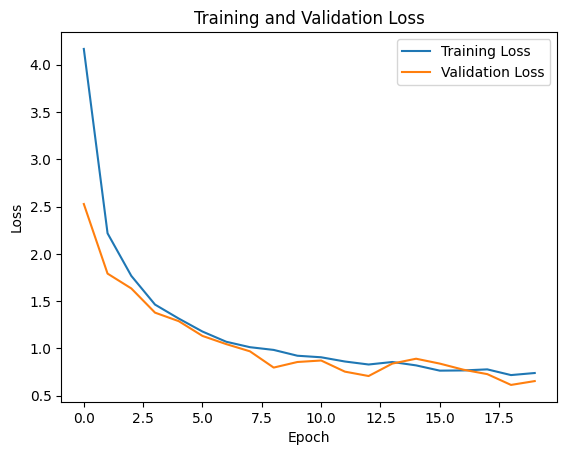

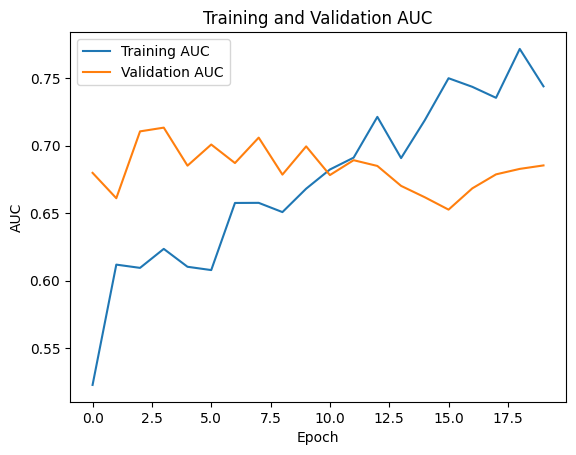

In [41]:

trainset = [train_frame_features_expanded, train_audio_features_expanded, train_tag_base_features_expanded]
trainlabels = train_labels_expanded
valset = [test_frame_features_expanded, test_audio_features_expanded, test_tag_base_features_expanded] 
vallabels = test_labels_expanded
class_weights_setup = class_weights_dict 
model32 = train_model(model32, 'model32', trainset, trainlabels, valset, vallabels, 
                     epochs=20, batch_size=32,
                     if_callback=True, class_weights_setup=class_weights_dict)


8/8 [==============================] - 1s 107ms/step
AUC: 0.7214700193423598

******************************Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90       235
         1.0       0.13      0.55      0.21        11

    accuracy                           0.82       246
   macro avg       0.55      0.69      0.56       246
weighted avg       0.94      0.82      0.87       246

[[196  39]
 [  5   6]]

******************************Evaluate metrics vs. Threshold for true class + Marco Recall


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


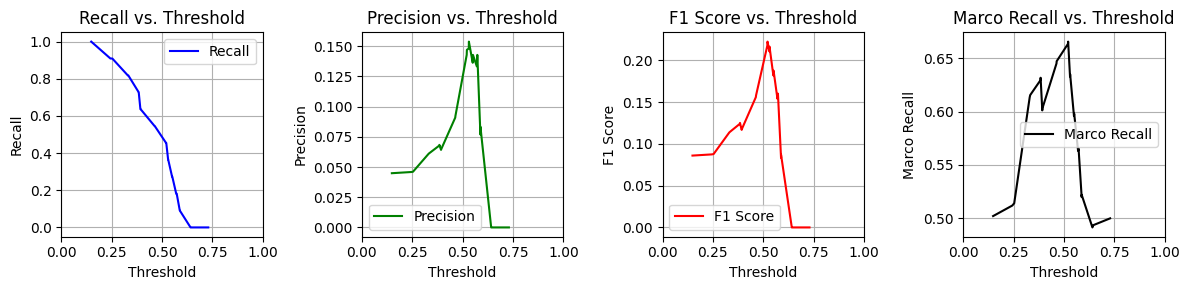


best recall_macro 0.6655705996131528
best_marco_recall_threshold 0.5211194
AUC: 0.7214700193423598

******************************Classification Report (Threshold = 0.5211194157600403):
              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92       235
         1.0       0.15      0.45      0.22        11

    accuracy                           0.86       246
   macro avg       0.56      0.67      0.57       246
weighted avg       0.93      0.86      0.89       246

[[206  29]
 [  6   5]]


In [42]:
model32_predictions = predict_and_average(model32, test_frame_features, test_audio_features, test_tag_base_features)

evaluate_default(model32_predictions)

plot_metrics_vs_threshold(test_labels, model32_predictions)



### MODEL 3.3 6 images + audio + BASE TAG

In [43]:
l2_reg = l2(0.004)

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet_base.layers:
    layer.trainable = False

input_image = Input(shape=(224, 224, 3), name='image_input')
input_audio = Input(shape=(1024,), name='audio_input')  # Assuming YAMNet outputs 1024-dimensional embeddings
fc_audio = Dense(100, activation='relu', kernel_regularizer=l2_reg, name='fc_audio')(input_audio)
input_tag_base = Input(shape=(4,), name='tag_base_input')  

image_features = resnet_base(input_image)
flatten_image = GlobalAveragePooling2D()(image_features)
fc_image = Dense(512, activation='relu', kernel_regularizer=l2_reg, name='fc_image')(flatten_image)

combined_features = Concatenate()([fc_image, fc_audio, input_tag_base])

fc1 = Dense(512, activation='relu', kernel_regularizer=l2_reg, name='fc1')(combined_features)
dropout1 = Dropout(0.6, name='dropout1')(fc1)
fc2 = Dense(256, activation='relu', kernel_regularizer=l2_reg, name='fc2')(dropout1)
dropout2 = Dropout(0.6, name='dropout2')(fc2)
output = Dense(1, activation='sigmoid', kernel_regularizer=l2_reg, name='output')(dropout2)

model33 = Model(inputs=[input_image, input_audio, input_tag_base], outputs=output)
model33.compile(optimizer='adam', 
                loss='binary_crossentropy', 
                metrics=[tf.keras.metrics.AUC(name='auc', curve='ROC')])

model33.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['image_input[0][0]']            
                                                                                                  
 global_average_pooling2d_2 (Gl  (None, 2048)        0           ['resnet50[0][0]']               
 obalAveragePooling2D)                                                                            
                                                                                            

Epoch 1/20
184/184 [==============================] - 33s 153ms/step - loss: 4.6310 - auc: 0.5564 - val_loss: 2.7569 - val_auc: 0.6945
Epoch 2/20
184/184 [==============================] - 27s 145ms/step - loss: 2.3627 - auc: 0.6559 - val_loss: 1.8647 - val_auc: 0.6920
Epoch 3/20
184/184 [==============================] - 27s 144ms/step - loss: 1.7825 - auc: 0.6921 - val_loss: 1.6102 - val_auc: 0.6057
Epoch 4/20
184/184 [==============================] - 27s 145ms/step - loss: 1.4937 - auc: 0.6947 - val_loss: 1.3213 - val_auc: 0.7048
Epoch 5/20
184/184 [==============================] - 25s 139ms/step - loss: 1.2546 - auc: 0.7389 - val_loss: 1.4417 - val_auc: 0.6879
Epoch 6/20
184/184 [==============================] - 26s 143ms/step - loss: 1.3121 - auc: 0.5572 - val_loss: 1.2218 - val_auc: 0.6800
Epoch 7/20
184/184 [==============================] - 26s 144ms/step - loss: 1.0965 - auc: 0.6801 - val_loss: 1.1047 - val_auc: 0.7146
Epoch 8/20
184/184 [==============================] - 2

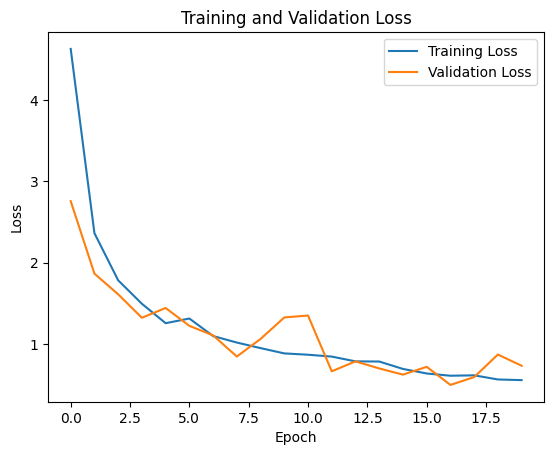

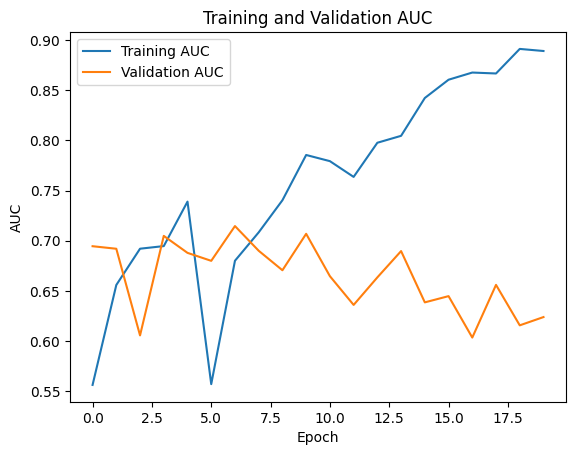

In [44]:

trainset = [train_frame_features_expanded, train_audio_features_expanded, train_tag_base_features_expanded]
trainlabels = train_labels_expanded
valset = [test_frame_features_expanded, test_audio_features_expanded, test_tag_base_features_expanded] 
vallabels = test_labels_expanded
class_weights_setup = class_weights_dict 
model33 = train_model(model33, 'model33', trainset, trainlabels, valset, vallabels, 
                     epochs=20, batch_size=32,
                     if_callback=True, class_weights_setup=class_weights_dict)


8/8 [==============================] - 1s 108ms/step
AUC: 0.6441005802707931

******************************Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

         0.0       0.98      0.69      0.81       235
         1.0       0.09      0.64      0.15        11

    accuracy                           0.69       246
   macro avg       0.53      0.66      0.48       246
weighted avg       0.94      0.69      0.78       246

[[162  73]
 [  4   7]]

******************************Evaluate metrics vs. Threshold for true class + Marco Recall


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


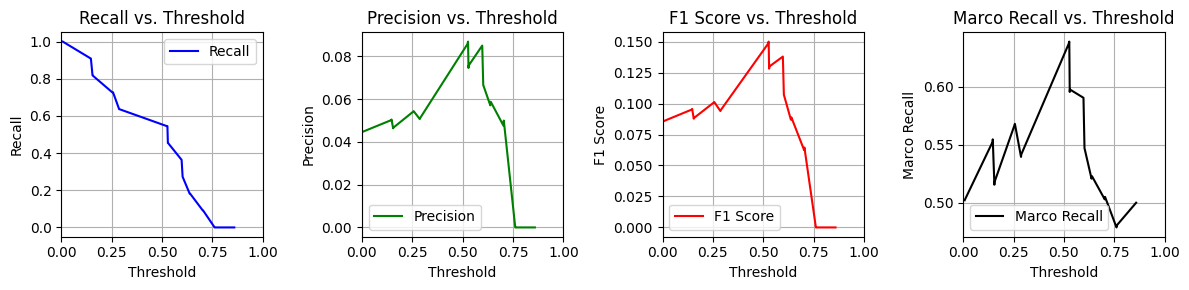


best recall_macro 0.6386847195357833
best_marco_recall_threshold 0.5268057
AUC: 0.6441005802707931

******************************Classification Report (Threshold = 0.5268056988716125):
              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83       235
         1.0       0.09      0.55      0.15        11

    accuracy                           0.72       246
   macro avg       0.53      0.64      0.49       246
weighted avg       0.93      0.72      0.80       246

[[172  63]
 [  5   6]]


In [45]:

model33_predictions = predict_and_average(model33, test_frame_features, test_audio_features, test_tag_base_features)

evaluate_default(model33_predictions)

plot_metrics_vs_threshold(test_labels, model33_predictions)



### MODEL 3.4 6 images + audio + ALL TAG

In [46]:

l2_reg = l2(0.004)

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the ResNet50 layers
for layer in resnet_base.layers:
    layer.trainable = False

input_image = Input(shape=(224, 224, 3), name='image_input')

input_audio = Input(shape=(1024,), name='audio_input')  # Assuming YAMNet outputs 1024-dimensional embeddings
fc_audio = Dense(100, activation='relu', kernel_regularizer=l2_reg, name='fc_audio')(input_audio)


input_tag = Input(shape=(TAG_N,), name='input_tag')  

image_features = resnet_base(input_image)
flatten_image = GlobalAveragePooling2D()(image_features)
fc_image = Dense(512, activation='relu', kernel_regularizer=l2_reg, name='fc_image')(flatten_image)


combined_features = Concatenate()([fc_image, fc_audio, input_tag])

fc1 = Dense(512, activation='relu', kernel_regularizer=l2_reg, name='fc1')(combined_features)
dropout1 = Dropout(0.6, name='dropout1')(fc1)
fc2 = Dense(256, activation='relu', kernel_regularizer=l2_reg, name='fc2')(dropout1)
dropout2 = Dropout(0.6, name='dropout2')(fc2)
output = Dense(1, activation='sigmoid', kernel_regularizer=l2_reg, name='output')(dropout2)

model34 = Model(inputs=[input_image, input_audio, input_tag], outputs=output)
model34.compile(optimizer='adam', 
                loss='binary_crossentropy', 
                metrics=[tf.keras.metrics.AUC(name='auc', curve='ROC')])

model34.summary()


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['image_input[0][0]']            
                                                                                                  
 global_average_pooling2d_3 (Gl  (None, 2048)        0           ['resnet50[0][0]']               
 obalAveragePooling2D)                                                                            
                                                                                            

Epoch 1/20
184/184 [==============================] - 33s 153ms/step - loss: 4.6237 - auc: 0.5677 - val_loss: 2.7512 - val_auc: 0.6395
Epoch 2/20
184/184 [==============================] - 27s 145ms/step - loss: 2.3570 - auc: 0.7012 - val_loss: 2.2303 - val_auc: 0.6982
Epoch 3/20
184/184 [==============================] - 27s 145ms/step - loss: 1.7564 - auc: 0.7272 - val_loss: 1.6611 - val_auc: 0.6320
Epoch 4/20
184/184 [==============================] - 27s 145ms/step - loss: 1.4749 - auc: 0.7467 - val_loss: 1.4049 - val_auc: 0.6770
Epoch 5/20
184/184 [==============================] - 27s 145ms/step - loss: 1.2499 - auc: 0.7551 - val_loss: 1.2800 - val_auc: 0.6557
Epoch 6/20
184/184 [==============================] - 27s 145ms/step - loss: 1.0805 - auc: 0.8059 - val_loss: 0.9976 - val_auc: 0.6741
Epoch 7/20
184/184 [==============================] - 27s 144ms/step - loss: 1.0256 - auc: 0.7921 - val_loss: 0.8060 - val_auc: 0.6741
Epoch 8/20
184/184 [==============================] - 2

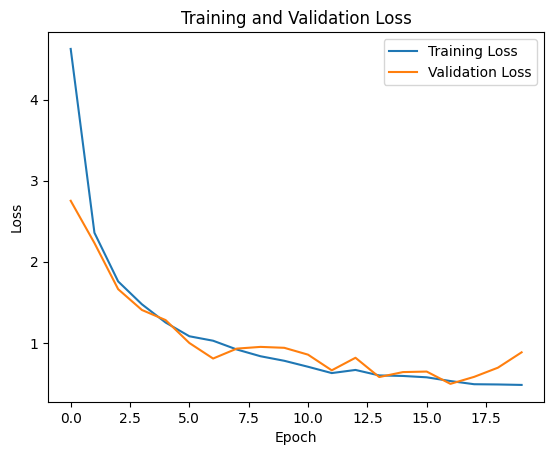

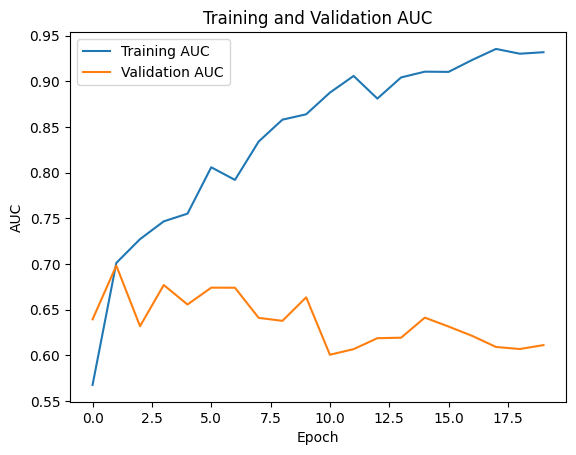

In [47]:
imputer = SimpleImputer(strategy='median')
train_tag_features_imputed = imputer.fit_transform(train_tag_features_expanded)
test_tag_features_imputed = imputer.transform(test_tag_features_expanded)


trainset = [train_frame_features_expanded, train_audio_features_expanded, train_tag_features_imputed]
trainlabels = train_labels_expanded
valset = [test_frame_features_expanded, test_audio_features_expanded, test_tag_features_imputed] 
vallabels = test_labels_expanded
class_weights_setup = class_weights_dict 
model34 = train_model(model34, 'model34', trainset, trainlabels, valset, vallabels, 
                     epochs=20, batch_size=32,
                     if_callback=True, class_weights_setup=class_weights_dict)


8/8 [==============================] - 1s 107ms/step
AUC: 0.6321083172147002

******************************Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84       235
         1.0       0.08      0.45      0.13        11

    accuracy                           0.73       246
   macro avg       0.52      0.60      0.48       246
weighted avg       0.93      0.73      0.81       246

[[174  61]
 [  6   5]]

******************************Evaluate metrics vs. Threshold for true class + Marco Recall


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


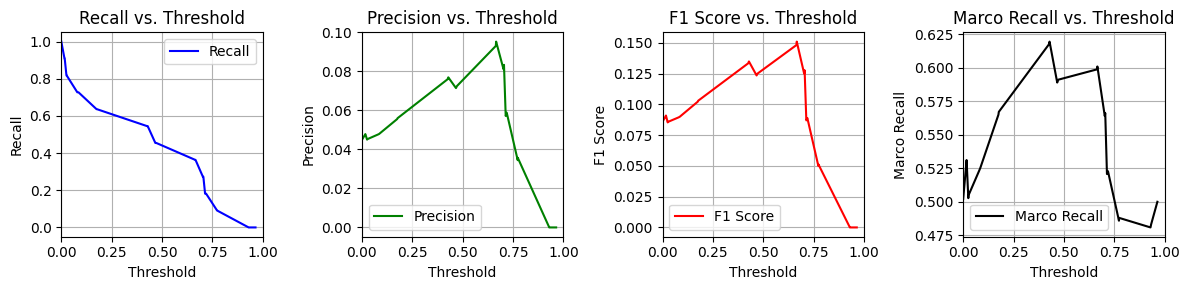


best recall_macro 0.6009671179883946
best_marco_recall_threshold 0.66624004
AUC: 0.6321083172147002

******************************Classification Report (Threshold = 0.6662400364875793):
              precision    recall  f1-score   support

         0.0       0.97      0.84      0.90       235
         1.0       0.10      0.36      0.15        11

    accuracy                           0.82       246
   macro avg       0.53      0.60      0.52       246
weighted avg       0.93      0.82      0.86       246

[[197  38]
 [  7   4]]


In [48]:

test_tag_features_imputed = imputer.transform(test_tag_features)


model34_predictions = predict_and_average(model34, test_frame_features, test_audio_features, test_tag_features_imputed)

evaluate_default(model34_predictions)

plot_metrics_vs_threshold(test_labels, model34_predictions)



## Summary


In [49]:
# Evaluate models
results_11  = evaluate_classification(test_labels, model11_predictions)
results_21  = evaluate_classification(test_labels, model21_predictions)
results_22  = evaluate_classification(test_labels, model22_predictions)
results_23  = evaluate_classification(test_labels, model23_predictions)
results_232 = evaluate_classification(test_labels, model232_predictions)
results_31  = evaluate_classification(test_labels, model31_predictions)
results_32  = evaluate_classification(test_labels, model32_predictions)
results_33  = evaluate_classification(test_labels, model33_predictions)
results_34  = evaluate_classification(test_labels, model34_predictions)

# Create a DataFrame
results_df = pd.DataFrame({
    '11: 1st Image (DNN Baseline)': results_11,
    '21: 6 Images (Pooling)': results_21,
    '22: 6 Images (Pooling) + Audio(1024d)': results_22,
    '23: 6 Images (Pooling) + Audio(1024d) + TAG(219d)': results_23,
    '232: 6 Images (Pooling) + Audio(1024d) + TAG(4d)': results_232,
    '31: Augment: 1 image': results_31,
    '32: Augment: 1 image TAG(4d)': results_32,
    '33: Augment: 1 image + Audio(1024d) + TAG(4d)': results_33,
    '34: Augment: 1 image + Audio(1024d) + TAG(219d)': results_34

})

# Transpose the DataFrame for better readability
results_df = results_df.T



In [50]:
def format_values(val):
    val = 100*val
    return f"{val:.0f}%"

# Apply formatting
styled_results_df = (results_df.style
    .format(format_values)
    .background_gradient(cmap='Greens')
    .set_properties(**{'width': '120px'}))

# Display the styled DataFrame
styled_results_df


,AUC,Accuracy,0-Precision,0-Recall,0-F1-Score,1-Precision,1-Recall,1-F1-Score,Macro-Precision,Macro-Recall,Macro-F1-Score,Weighted-Precision,Weighted-Recall,Weighted-F1-Score
11: 1st Image (DNN Baseline),56%,74%,96%,75%,84%,6%,36%,11%,51%,56%,48%,92%,74%,81%
21: 6 Images (Pooling),42%,59%,94%,60%,74%,2%,18%,4%,48%,39%,39%,90%,59%,70%
22: 6 Images (Pooling) + Audio(1024d),49%,87%,95%,91%,93%,0%,0%,0%,48%,46%,47%,91%,87%,89%
23: 6 Images (Pooling) + Audio(1024d) + TAG(219d),48%,90%,95%,94%,95%,0%,0%,0%,48%,47%,47%,91%,90%,91%
232: 6 Images (Pooling) + Audio(1024d) + TAG(4d),48%,89%,95%,94%,94%,0%,0%,0%,48%,47%,47%,91%,89%,90%
24: 6 Images (Stack) + Audio(1024d) + TAG(4d),63%,86%,95%,90%,93%,4%,9%,6%,50%,49%,49%,91%,86%,89%
31: Augment: 1 image,71%,70%,98%,70%,82%,9%,64%,16%,53%,67%,49%,94%,70%,79%
32: Augment: 1 image TAG(4d),72%,82%,98%,83%,90%,13%,55%,21%,55%,69%,56%,94%,82%,87%
33: Augment: 1 image + Audio(1024d) + TAG(4d),64%,69%,98%,69%,81%,9%,64%,15%,53%,66%,48%,94%,69%,78%
34: Augment: 1 image + Audio(1024d) + TAG(219d),63%,73%,97%,74%,84%,8%,45%,13%,52%,60%,48%,93%,73%,81%


## Best Model - Explainability

In [ ]:
from tensorflow.keras.models import load_model

final_model = load_model('model_checkpoints/final_model-2024-08-15_14:39:54.h5')

model32_predictions = predict_and_average(final_model, test_frame_features, test_tag_base_features)

evaluate_default(model32_predictions, test_labels)
plot_metrics_vs_threshold(test_labels, model32_predictions)



In [ ]:

final_predictions = []
for i in range(test_frame_features.shape[1]):  # Iterate over the 6 images
    image = test_frame_features[:, i, :, :, :]
    tags = test_tag_base_features
    pred = final_model.predict([image, tags])
    final_predictions.append(pred)

df = pd.DataFrame(np.array(final_predictions).reshape(6, 246).T, columns=['1', '2', '3', '4', '5', '6'])

means = df.median()
# sorted_columns = means.sort_values().index
# df_sorted = df[sorted_columns]
df_melted = df.melt(var_name='Set', value_name='Values')
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Set', y='Values', data=df_melted)
for i, set_name in enumerate(['1', '2', '3', '4', '5', '6']):
    mean_val = means[set_name]
    ax.text(i, mean_val + 0.02, f'{mean_val:.2f}', ha='center', va='bottom', fontsize=10, color='black')
plt.title('Box Plot of Predictions For Each Image')
plt.xlabel('Images')
plt.ylabel('Prediction')
plt.show()



df = pd.DataFrame(np.array(final_predictions).reshape(6, 246).T, columns=['1', '2', '3', '4', '5', '6'])
df['target'] = test_labels
df_melted = df.melt(var_name='Set', id_vars=['target'], value_name='Values')
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Set', y='Values', data=df_melted, hue='target')
plt.title('Box Plot of Predictions For Each Image By Real Target')
plt.xlabel('Images')
plt.ylabel('Prediction')
plt.show()


In [ ]:
pred_pos_creatives = set(np.array(test_creative_code)[np.where((model32_predictions>=0.5) == 1)[0]])
real_pos_creatives = set(np.array(test_creative_code)[np.where(test_labels == 1)[0]])
true_positive_samples = real_pos_creatives.intersection(pred_pos_creatives)
print(true_positive_samples)

In [ ]:
indices = np.where(test_labels == 1)[0]
print(np.array(test_creative_code)[indices])

In [ ]:

def get_gradcam_heatmap(model, img_array, tag_array, last_conv_layer_name, pred_index=None):
    with tf.device('/CPU:0'):
        grad_model = Model(
            [model.inputs], 
            [model.get_layer(last_conv_layer_name).output, model.output]
        )

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model([img_array, tag_array])
            if pred_index is None:
                pred_index = tf.argmax(predictions[0])
            class_channel = predictions[:, pred_index]

        grads = tape.gradient(class_channel, conv_outputs)

        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        conv_outputs = conv_outputs[0]
        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()
    
def reverse_preprocess(img):
    # Convert from BGR to RGB (since preprocess_input might convert it)
    img = img[..., ::-1]
    mean = np.array([103.939, 116.779, 123.68])
    img = img + mean
    img = np.clip(img, 0, 255)
    return img 

def display_gradcam(img_array, heatmap, info, alpha=0.3):
    img = img_array[0]
    
    img = reverse_preprocess(img)
    img = img.astype('uint8')

    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (img.shape[0], img.shape[1]))
    heatmap_resized = tf.squeeze(heatmap_resized, axis=-1)
    heatmap_3d = tf.stack([heatmap_resized] * 3, axis=-1)    
    heatmap_normalized = heatmap_3d / tf.reduce_max(heatmap_3d)
    
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (img.shape[0], img.shape[1]))
    heatmap_resized = tf.squeeze(heatmap_resized, axis=-1)

    heatmap2d_normalized = heatmap_resized / tf.reduce_max(heatmap_resized)

    jet_heatmap = plt.cm.viridis(heatmap2d_normalized.numpy())[:, :, :3]  # Use 'plasma' or 'viridis'
    img = tf.cast(img, dtype=tf.float32) / 255.0

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.uint8(255 * superimposed_img)

    fig = plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # # Heatmap
    # plt.subplot(1, 4, 2)
    # plt.imshow(heatmap_normalized, cmap='jet')
    # plt.title('Heatmap')
    # plt.axis('off')

    # Heatmap - REFINED 
    plt.subplot(1, 3, 2)
    plt.imshow(jet_heatmap)
    plt.title('Refined Heatmap')
    plt.axis('off')

    # Superimposed image
    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title('Superimposed Image')
    plt.axis('off')
    code = info['code']
    no_img = info['no_img']
    pred_score = info['pred_score']
    fig.suptitle(f'Creative: {code} [No.{no_img}] - Model Pred = {pred_score:.2f}')      
    fig.savefig(f'images_output/{code}_{no_img}.png')
    plt.show()

for creative_code in true_positive_samples:
    print('#'*50, creative_code, '#'*50,)
    hero_creative_index = np.where(np.array(test_creative_code_expanded) == creative_code)[0]

    img_array = tf.gather(test_frame_features_expanded, hero_creative_index.tolist())
    tag_array = tf.gather(test_tag_base_features_expanded, hero_creative_index.tolist()) 
    last_conv_layer_name = "conv5_block3_out"   

    preds = final_model.predict([img_array,tag_array])

    for i in range(6):
        img = tf.expand_dims(img_array[i], axis=0)
        tag = tf.expand_dims(tag_array[i], axis=0) 
        heatmap = get_gradcam_heatmap(final_model, img, tag, last_conv_layer_name)
        display_gradcam(img, heatmap, info= {'code':creative_code, 'no_img': i, 'pred_score':preds[i][0]})
    print()

    
